# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

Работа выполнена студентами группы М8О-411Б-19: \
Терешков Алексей \
Мамченков Дмитрий \
Алимов Исмаил

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [10]:
import pandas as pd
import numpy as np
import random

import apimoex
import requests

import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

In [11]:
stock_names = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']
start_date = '2020-04-01' 
end_date = '2022-04-22'

In [12]:
def load_data(stock_names=stock_names, start=start_date, end=end_date):
    df = pd.DataFrame()
    with requests.Session() as session:
        for stock in stock_names:
            data = apimoex.get_board_history(session, stock, start=start, end=end, columns=['CLOSE', 'TRADEDATE'])
            df_stock = pd.DataFrame(data)
            df_stock.set_index('TRADEDATE', inplace=True)
            df[stock] = df_stock
    return df


def prepare_r(df_stocks):
    return (df_stocks.shift(-1) / df_stocks).dropna()

In [13]:
data = load_data()
data_clear = data.dropna()
r = prepare_r(data_clear)

In [14]:
data_clear.head()

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050


In [15]:
r.head()

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,1.016776,1.038765,1.005548,1.011744,0.998039,1.008079
2020-04-02,0.996982,1.014596,1.041933,0.992993,1.053045,0.994991
2020-04-03,1.018365,1.007008,1.035798,1.027257,1.014925,1.037253
2020-04-06,0.980777,1.000628,1.003272,1.036340,1.007353,1.011454
2020-04-07,1.017175,1.015113,1.019160,1.013459,0.979927,0.988484


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

<AxesSubplot: xlabel='TRADEDATE'>

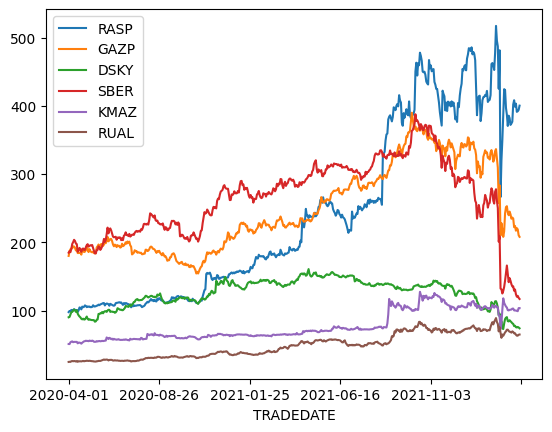

In [16]:
data_clear.plot()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [17]:
data_clear

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050
...,...,...,...,...,...,...
2022-04-18,403.15,216.99,75.60,123.85,100.1,64.605
2022-04-19,391.15,220.72,75.20,120.30,99.5,63.200
2022-04-20,392.00,218.92,75.98,121.50,99.1,63.200


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

Заменим операцию $ r_t^\top x_t$ на $ (\vec{r_t} \cdot \vec{x_t})$

В таком случае:
$$ f_t(x) = -\log (\vec{r} \cdot \vec{x}) $$

$$\nabla f_t(x) = -\frac{\vec{r}} {(\vec{r} \cdot \vec{x})} $$

Формула перехода:
$$ x_{t+1} = \Pi_{\mathcal{D}}(x_t - \alpha_t\nabla f_t(x_t)) $$ 
 


Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [18]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [19]:
def get_grad(r, x):
    return -r / np.dot(r, x)

In [20]:
def descent_step(this_state, r, alpha, grad_func):
    x = this_state
    new_x = simplex_projection(x - alpha * grad_func(r, x))
    return new_x


def descent(begin_state, df_r, grad_func, lr_scheduler=lambda i: 0.1):
    x = begin_state

    n = df_r.shape[0]

    profit = []
    vectors = [x]

    profit = 1.0
    profit_vec = [profit]

    for i in range(n):
        r = df_r.iloc[i].values  # "после этого алгоритму открывается вектор рыночных доходностей rt из истории наблюдений"
        alpha = lr_scheduler(i)
        profit *= (r * x).sum()
        profit_vec.append(profit)
        new_x = descent_step(x, r, alpha, grad_func) # "алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации."
        x = new_x # в момент времени t алгоритм должен предложить распределение средств между активами xt 
        vectors.append(new_x)

    return (vectors, profit_vec)
    

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Выбор длины шага

Длину шага выберем ситуативно, но вне зависимости от ситуации оставим его константной, так как ситуация на рынке меняется, а затухающая длина шага будет способствовать застыванию наших ответов, отчего на дистанции будет решать ситуация на рынке, которая была в начале.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [21]:
alpha_array = np.logspace(1, 10, 1000, base=5.1) * 0.0001

In [22]:
max_profit = [0]
best_alpha = -1.0

for i in alpha_array:
    vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_grad, lr_scheduler=lambda x: i)
    if profit[-1] > max_profit[-1]:
      max_profit = profit
      best_alpha = i

In [23]:
best_alpha

0.43635803556937275

Для данного метода лучшей константой alpha оказалась 0.436358

In [24]:
profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
profit_to_date['profit'] = max_profit

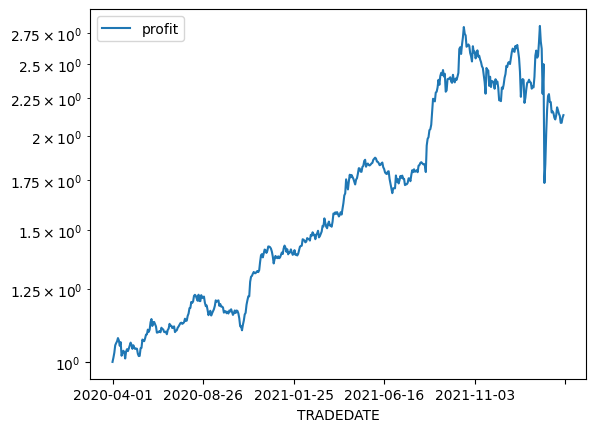

In [25]:
graph = profit_to_date.plot()
graph.set_yscale('log')

In [26]:
#final profit
profit_to_date['profit'][-1]

2.1356268078260854

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [27]:
def get_sgrad(r, x):
    rdot = np.dot(r, x)
    rand_value = random.randint(0, 5)
    new_r = np.array([0 for i in range(6)])
    new_r[rand_value] = r[rand_value]
    return -new_r / rdot

In [44]:
vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_sgrad, lr_scheduler=lambda x: 0.5)

In [45]:
profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
profit_to_date['profit'] = profit

<AxesSubplot: xlabel='TRADEDATE'>

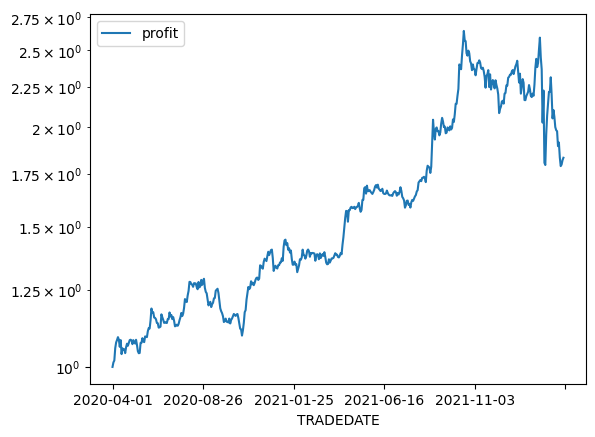

In [46]:
graph = profit_to_date.plot()
graph.set_yscale('log')
graph

In [47]:
#final profit
profit_to_date['profit'][-1]

1.8316396002353397

In [32]:
profit_list = []
for i in range(1000):
    vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_sgrad, lr_scheduler=lambda x: 0.5)
    profit_list.append(profit[-1])

In [33]:
osgd_average_profit = np.average(profit_list)

osgd_max_profit = np.max(profit_list)
osgd_min_profit = np.min(profit_list)

In [34]:
osgd_average_profit / max_profit[-1]

0.7219149365674529

In [35]:
osgd_max_profit / max_profit[-1]

1.7198595909573509

In [36]:
osgd_min_profit / max_profit[-1]

0.2886515705765898

In [37]:
max_profit[-1]

2.1356268078260854

In [38]:
vectors, naive_profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_grad, lr_scheduler=lambda x: 0)

In [39]:
naive_profit[-1]

1.7014992521179437

Вывод: 

Наивный алгоритм (если взять равномерно все активы и не пересобирать портфель) выдает прибыльность 1.7. Алгоритм OGD выдает прибыльность 2.14.

Алгоритм OSGD в среднем слабее, чем алгоритм OGD, однако в некоторых случайных случаях он может выдать результат больший в ~1.4 раз. 

Алгоритм OGD приносит прибыли не сильно выше роста рынка, однако ситуация на рынке не предсказывается очевидным образом, и даже такой результат - уже отлично.

Алгоритм OSGD лучше не использовать, в среднем он менее выгоден, чем OGD.